In [26]:
import cv2 as cv
import argparse
import numpy as np
import os.path
import sys
import random
import matplotlib.pyplot as plt
%matplotlib inline

**Initialize**

In [ ]:
# Initialize the parameters
confThreshold = 0.5  # Confidence threshold
maskThreshold = 0.3  # Mask threshold

class Args(object):
    def __init__(self, **params):
        self.image = params.get('image', 'cars.jpg')
        self.video = params.get('video', 'cars.mp4')

args = Args()        
print (args.image, args.video)

**Define functions**

In [5]:
# Draw the predicted bounding box, colorize and show the mask on the image
def drawBox(frame, classId, conf, left, top, right, bottom, classMask):
    # Draw a bounding box.
    cv.rectangle(frame, (left, top), (right, bottom), (255, 178, 50), 3)
    
    # Print a label of class.
    label = '%.2f' % conf
    if classes:
        assert(classId < len(classes))
        label = '%s:%s' % (classes[classId], label)
    
    # Display the label at the top of the bounding box
    labelSize, baseLine = cv.getTextSize(label, cv.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
    cv.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine), (255, 255, 255), cv.FILLED)
    cv.putText(frame, label, (left, top), cv.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 1)

    # Resize the mask, threshold, color and apply it on the image
    classMask = cv.resize(classMask, (right - left + 1, bottom - top + 1))
    mask = (classMask > maskThreshold)
    roi = frame[top:bottom+1, left:right+1][mask]

    # color = colors[classId%len(colors)]
    # Comment the above line and uncomment the two lines below to generate different instance colors
    colorIndex = random.randint(0, len(colors)-1)
    color = colors[colorIndex]

    frame[top:bottom+1, left:right+1][mask] = ([0.3*color[0], 0.3*color[1], 0.3*color[2]] + 0.7 * roi).astype(np.uint8)

    # Draw the contours on the image
    mask = mask.astype(np.uint8)
    contours, hierarchy = cv.findContours(mask,cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)
    cv.drawContours(frame[top:bottom+1, left:right+1], contours, -1, color, 3, cv.LINE_8, hierarchy, 100)

# For each frame, extract the bounding box and mask for each detected object
def postprocess(boxes, masks):
    # Output size of masks is NxCxHxW where
    # N - number of detected boxes
    # C - number of classes (excluding background)
    # HxW - segmentation shape
    numClasses = masks.shape[1]
    numDetections = boxes.shape[2]

    frameH = frame.shape[0]
    frameW = frame.shape[1]

    for i in range(numDetections):
        box = boxes[0, 0, i]
        mask = masks[i]
        score = box[2]
        if score > confThreshold:
            classId = int(box[1])
            
            # Extract the bounding box
            left = int(frameW * box[3])
            top = int(frameH * box[4])
            right = int(frameW * box[5])
            bottom = int(frameH * box[6])
            
            left = max(0, min(left, frameW - 1))
            top = max(0, min(top, frameH - 1))
            right = max(0, min(right, frameW - 1))
            bottom = max(0, min(bottom, frameH - 1))
            
            # Extract the mask for the object
            classMask = mask[classId]

            # Draw bounding box, colorize and show the mask on the image
            drawBox(frame, classId, score, left, top, right, bottom, classMask)

**Load the model and classes**

In [6]:
# Load names of classes
classesFile = "mscoco_labels.names";
classes = None
with open(classesFile, 'rt') as f:
   classes = f.read().rstrip('\n').split('\n')

# Give the textGraph and weight files for the model
textGraph = "./mask_rcnn_inception_v2_coco_2018_01_28.pbtxt";
modelWeights = "./mask_rcnn_inception_v2_coco_2018_01_28/frozen_inference_graph.pb";

# Load the network
net = cv.dnn.readNetFromTensorflow(modelWeights, textGraph);
net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv.dnn.DNN_TARGET_CPU)

# Load the classes
colorsFile = "colors.txt";
with open(colorsFile, 'rt') as f:
    colorsStr = f.read().rstrip('\n').split('\n')
colors = [] #[0,0,0]
for i in range(len(colorsStr)):
    rgb = colorsStr[i].split(' ')
    color = np.array([float(rgb[0]), float(rgb[1]), float(rgb[2])])
    colors.append(color)


**Read the input**

In [21]:
outputFile = "mask_rcnn_out_py.avi"
if (args.image):
    # Open the image file
    if not os.path.isfile(args.image):
        print("Input image file ", args.image, " doesn't exist")
        sys.exit(1)
    cap = cv.VideoCapture(args.image)
    outputFile = args.image[:-4]+'_mask_rcnn_out_py.jpg'
elif (args.video):
    # Open the video file
    if not os.path.isfile(args.video):
        print("Input video file ", args.video, " doesn't exist")
        sys.exit(1)
    cap = cv.VideoCapture(args.video)
    outputFile = args.video[:-4]+'_mask_rcnn_out_py.avi'
else:
    # Webcam input
    cap = cv.VideoCapture(0)

# Get the video writer initialized to save the output video
if (not args.image):
    vid_writer = cv.VideoWriter(outputFile, cv.VideoWriter_fourcc('M','J','P','G'), 28, (round(cap.get(cv.CAP_PROP_FRAME_WIDTH)),round(cap.get(cv.CAP_PROP_FRAME_HEIGHT))))


**Process each frame**

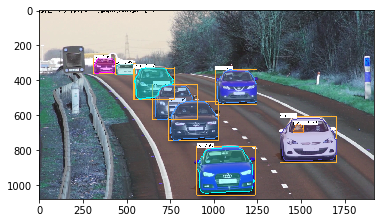

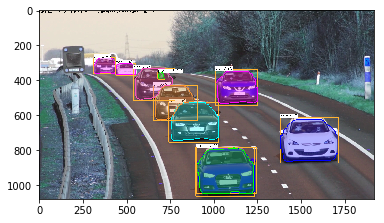

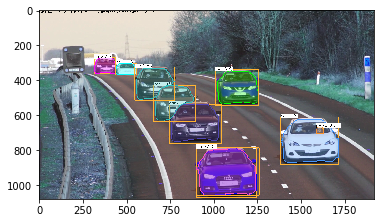

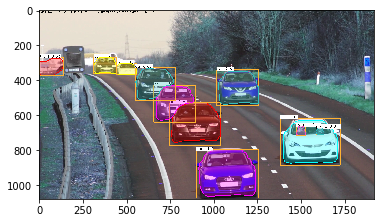

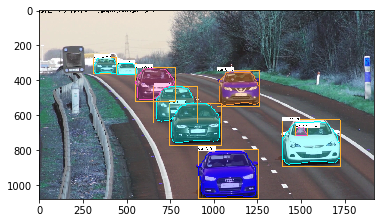

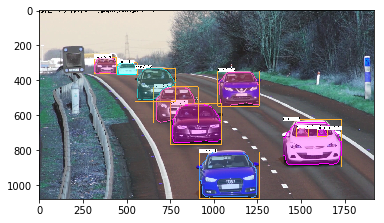

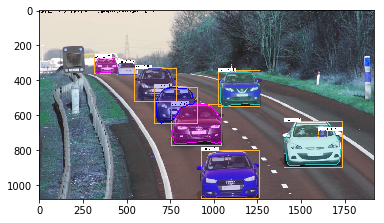

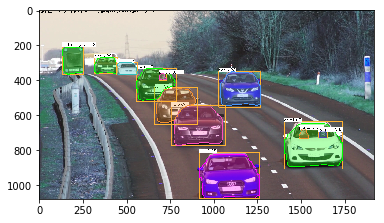

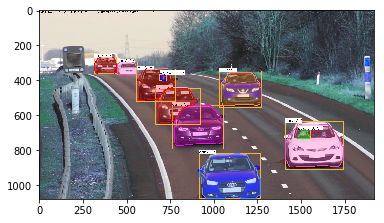

In [35]:
try:
    while True:
        index = index + 1
        # Get frame from the video
        hasFrame, frame = cap.read()
    #     print (hasFrame, frame)

        # Stop the program if reached end of video
        if not hasFrame:
            print("Done processing !!!")
            print("Output file is stored as ", outputFile)
            break

        # Create a 4D blob from a frame.
        blob = cv.dnn.blobFromImage(frame, swapRB=True, crop=False)

        # Set the input to the network
        net.setInput(blob)

        # Run the forward pass to get output from the output layers
        boxes, masks = net.forward(['detection_out_final', 'detection_masks'])

        # Extract the bounding box and mask for each of the detected objects
        postprocess(boxes, masks)
    #     print (boxes, masks)

        # Put efficiency information.
        t, _ = net.getPerfProfile()
        label = 'Mask-RCNN on 2.5 GHz Intel Core i7 CPU, Inference time for a frame : %0.0f ms' % abs(t * 1000.0 / cv.getTickFrequency())
        cv.putText(frame, label, (0, 15), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))

        # Write the frame with the detection boxes
        if (args.image):
            cv.imwrite(outputFile, frame.astype(np.uint8));
        else:
            vid_writer.write(frame.astype(np.uint8))
        
        # matplot as background so we can draw one by one
        # to break the loop, press ESC, then I twice
        plt.imshow(frame)
        plt.show()
    
except KeyboardInterrupt:
    pass
    